In [1]:
import os
import argparse
import numpy as np
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import cifar10_input
from pgd_attack import PGDAttackDetector, PGDAttackClassifier
from model import Model, BayesClassifier
from eval_utils import BaseDetectorFactory, batched_run, eps8_attack_config
from scipy.special import softmax
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt

In [2]:
sess = tf.Session()

In [3]:
attack_config = {'epsilon': 25500, 'num_steps': 200, 
               'step_size': 0.5*255, 'random_start': False, 'norm': 'L2'}
np.random.seed(123)
noise = np.random.randn(1, 32, 32, 3).clip(0, 1)*255

In [4]:
classifier = Model(mode='eval', var_scope='classifier')
classifier_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                    scope='classifier')
classifier_saver = tf.train.Saver(var_list=classifier_vars)
classifier_saver.restore(sess, 'models/adv_trained_prefixed_classifier/checkpoint-70000')

In [46]:
target_class = 9
detector_var_scope = 'detector-class{}'.format(target_class)

detector = Model(mode='eval',
                 var_scope=detector_var_scope,
                 target_class=target_class)
detector_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                  scope=detector_var_scope)
detector_saver = tf.train.Saver(var_list=detector_vars)
detector_saver.restore(sess, 'models/cifar10_ovr_Linf_16.0_iter80_lr0.5_bs300/class{}/checkpoint-10000'.format(target_class))

In [47]:
steps = [0, 50, 100, 150, 200]
samples, logits = [], []
for step in steps:
    attack_config = {'epsilon': 255000, 'num_steps': step, 
                   'step_size': 0.5*255, 'random_start': False, 'norm': 'L2'}
    detector_attack = PGDAttackDetector(detector, loss_func='cw', **attack_config)
    detector_sample = detector_attack.perturb(noise, np.zeros(noise.shape[0]), sess)
    logit_out = sess.run(detector.target_logits, feed_dict={detector.x_input: detector_sample})
    samples.append(detector_sample[0])
    logits.append(logit_out[0])

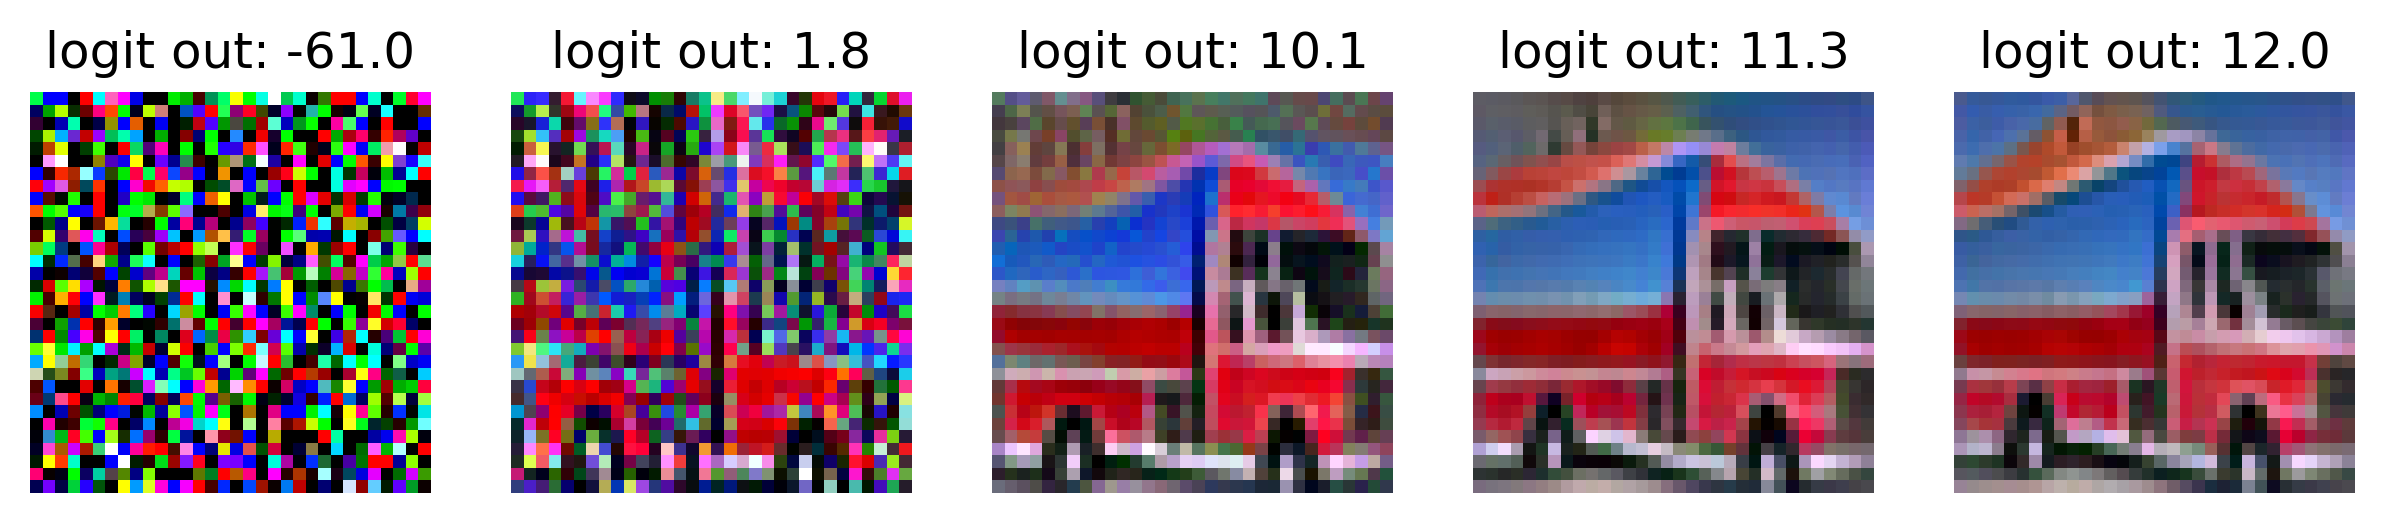

In [48]:
fig, axes = plt.subplots(ncols=len(steps), figsize=(10, 2), dpi=300)
for step, sample, logit, ax in zip(steps, samples, logits, axes):
    ax.imshow(sample/255)
    ax.set_title('logit out: {:.1f}'.format(logit, step))
    ax.set_axis_off()

In [49]:
classifier_samples, classifier_logits = [], []
for step in steps:
    attack_config = {'epsilon': 255000, 'num_steps': step, 
                   'step_size': 0.5*255, 'random_start': False, 'norm': 'L2'}
    classifier_attack = PGDAttackClassifier(classifier=classifier, loss_func='cw', targeted=True, **attack_config)
    classifier_sample = classifier_attack.perturb(noise, np.zeros(noise.shape[0])+target_class, sess)
    logit_out = sess.run(classifier.logits, feed_dict={classifier.x_input: classifier_sample})[:, target_class]
    classifier_samples.append(classifier_sample[0])
    classifier_logits.append(logit_out[0])

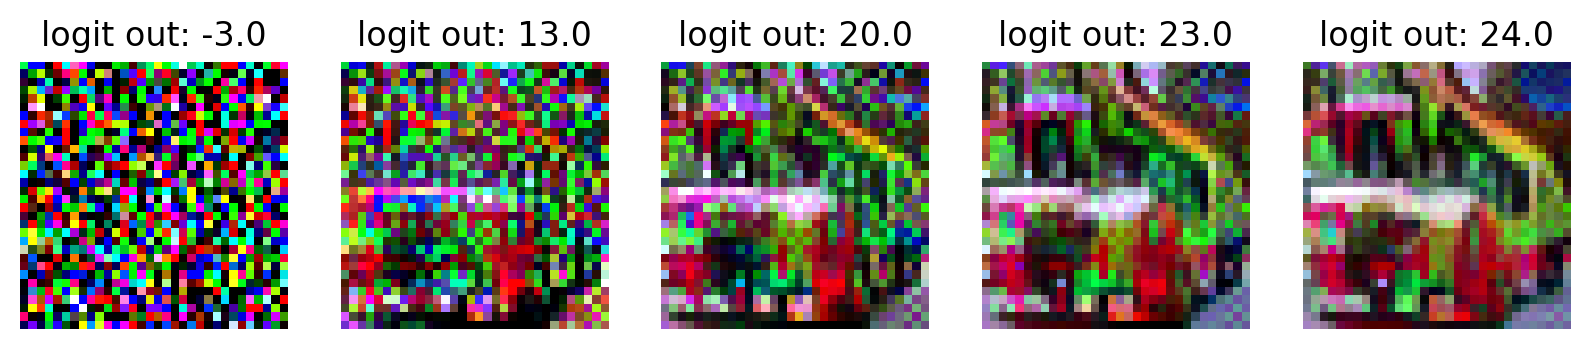

In [50]:
fig, axes = plt.subplots(ncols=len(steps), figsize=(10, 2), dpi=200)
for step, sample, logit, ax in zip(steps, classifier_samples, classifier_logits, axes):
    ax.imshow(sample/255)
    ax.set_title('logit out: {:.1f}'.format(int(logit), step))
    ax.set_axis_off()

In [51]:
out1 = sess.run(detector.target_logits, feed_dict={detector.x_input: np.array(classifier_samples)})
out2 = sess.run(classifier.logits, feed_dict={classifier.x_input: np.array(samples)})[:, target_class]
print(np.around(out1, 1), np.around(out2, 1))

[-61.  -15.2  -3.2  -2.6  -2.8] [-3.6  7.6 10.   9.8  9.6]
